In [1]:
# Cell 1: Library Imports and Configuration
"""
GT-XGBoost: Google Trends-Augmented XGBoost for VIX Volatility Prediction
Professional Implementation for Academic Publication

This implementation develops a machine learning early warning system that integrates
Google search sentiment with traditional volatility indicators for market spike prediction.
"""

# Core data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Machine learning and model evaluation
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, 
    precision_recall_curve, accuracy_score, roc_auc_score
)

# Statistical analysis
from scipy import stats
from scipy.stats import zscore

# Academic finance models
try:
    from arch import arch_model
    ARCH_AVAILABLE = True
except ImportError:
    print("Installing ARCH package for academic volatility models...")
    import subprocess
    subprocess.check_call(["pip", "install", "arch"])
    from arch import arch_model
    ARCH_AVAILABLE = True

# Publication-quality visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Configure publication-quality plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Academic plotting parameters
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'font.size': 10,
    'lines.linewidth': 2,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Professional color scheme
COLORS = {
    'primary': '#2E86AB',      # Professional blue
    'secondary': '#A23B72',    # Academic purple  
    'accent': '#F18F01',       # Highlight orange
    'success': '#C73E1D',      # Validation red
    'neutral': '#6C757D',      # Reference gray
    'vix': '#FF6B6B',         # VIX indicator
    'trends': '#4ECDC4',      # Google Trends
    'benchmark': '#95A5A6'     # Benchmark gray
}

# Model configuration parameters
VIX_THRESHOLD = 30      # Standard VIX spike threshold
RANDOM_STATE = 42       # Reproducibility seed
CV_SPLITS = 5           # Time series cross-validation folds

print("=" * 60)
print("📊 GT-XGBOOST VOLATILITY PREDICTION SYSTEM")
print("=" * 60)
print("✅ Core libraries imported successfully")
print("✅ Academic plotting configuration applied")
print("✅ Professional color scheme loaded")
print(f"✅ VIX spike threshold: {VIX_THRESHOLD}")
print(f"✅ Random state: {RANDOM_STATE}")
print(f"✅ Cross-validation folds: {CV_SPLITS}")
print("✅ System ready for GT-XGBoost implementation")

Installing ARCH package for academic volatility models...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 18.3 MB/s eta 0:00:00
📊 GT-XGBOOST VOLATILITY PREDICTION SYSTEM
✅ Core libraries imported successfully
✅ Academic plotting configuration applied
✅ Professional color scheme loaded
✅ VIX spike threshold: 30
✅ Random state: 42
✅ Cross-validation folds: 5
✅ System ready for GT-XGBoost implementation


In [2]:
# Cell 2: Data Loading and Preparation
"""
Data Acquisition and Preprocessing Pipeline
- VIX daily data (CBOE Volatility Index)
- Google Trends search volume data (behavioral sentiment indicators)
- Auxiliary market data for validation
"""

def load_vix_data(file_path):
    """Load and preprocess VIX data from CBOE format"""
    # Load data with proper header handling
    df = pd.read_csv(file_path, skiprows=5)
    
    # Standardize column names
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close'] if len(df.columns) >= 5 else ['Date', 'Open', 'High', 'Low']
    
    # Convert to datetime and clean
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    
    print(f"✅ VIX data loaded: {len(df):,} daily observations")
    print(f"   Coverage: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
    
    return df

def load_google_trends(file_path, term_name):
    """Load and preprocess Google Trends behavioral data"""
    try:
        # Load trends data with header skip
        df = pd.read_csv(file_path, skiprows=2)
        
        if df.empty or len(df.columns) < 2:
            print(f"❌ Warning: {term_name} data validation failed")
            return None
        
        # Standardize format
        df.columns = ['Month', 'Interest']
        
        # Standardize monthly dates (15th of each month)
        df['Month'] = pd.to_datetime(df['Month'] + '-15', errors='coerce')
        
        # Clean and validate
        df = df.dropna(subset=['Month']).sort_values('Month').reset_index(drop=True)
        
        print(f"✅ {term_name} trends loaded: {len(df):,} monthly observations")
        
        return df
    
    except Exception as e:
        print(f"❌ Error processing {term_name}: {e}")
        return None

def load_auxiliary_data(file_path):
    """Load auxiliary market data for model validation"""
    try:
        df = pd.read_csv(file_path)
        
        # Clean formatting artifacts
        df.columns = [col.strip('"') for col in df.columns]
        for col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.replace('"', '')
        
        # Process date and price columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        if 'Price' in df.columns:
            df['Price'] = df['Price'].str.replace(',', '').astype(float)
        
        # Clean and validate
        df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
        
        print(f"✅ Auxiliary data loaded: {len(df):,} daily observations")
        print(f"   Coverage: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
        
        return df
    
    except Exception as e:
        print(f"❌ Error processing auxiliary data: {e}")
        return None

def aggregate_vix_monthly(vix_df):
    """Aggregate daily VIX data to monthly frequency for GT-XGBoost model"""
    # Extract temporal components
    vix_df = vix_df.copy()
    vix_df['Year'] = vix_df['Date'].dt.year
    vix_df['Month_Num'] = vix_df['Date'].dt.month
    
    # Identify available VIX metrics
    available_cols = list(vix_df.columns)
    print(f"Available VIX metrics: {[col for col in available_cols if col not in ['Date', 'Year', 'Month_Num']]}")
    
    # Configure aggregation strategy
    agg_dict = {'Date': 'first'}
    
    if 'High' in available_cols:
        agg_dict['High'] = ['mean', 'max', 'std']
    if 'Low' in available_cols:
        agg_dict['Low'] = 'mean'
    if 'Open' in available_cols:
        agg_dict['Open'] = 'mean'
    if 'Close' in available_cols:
        agg_dict['Close'] = 'mean'
    
    # Perform monthly aggregation
    monthly_vix = vix_df.groupby(['Year', 'Month_Num']).agg(agg_dict).reset_index()
    
    # Flatten hierarchical columns and rename systematically
    new_columns = ['Year', 'Month_Num']
    
    for col in monthly_vix.columns[2:]:
        if isinstance(col, tuple):
            if col[0] == 'High' and col[1] == 'mean':
                new_columns.append('Avg_VIX')
            elif col[0] == 'High' and col[1] == 'max':
                new_columns.append('Max_VIX')
            elif col[0] == 'High' and col[1] == 'std':
                new_columns.append('VIX_Std')
            elif col[0] == 'Low' and col[1] == 'mean':
                new_columns.append('Low_VIX')
            elif col[0] == 'Open' and col[1] == 'mean':
                new_columns.append('Open_VIX')
            elif col[0] == 'Close' and col[1] == 'mean':
                new_columns.append('Close_VIX')
            elif col[0] == 'Date' and col[1] == 'first':
                new_columns.append('First_Date')
            else:
                new_columns.append(f"{col[0]}_{col[1]}")
        else:
            new_columns.append(col)
    
    monthly_vix.columns = new_columns
    
    # Create standardized monthly timestamps
    monthly_vix['Month'] = pd.to_datetime(
        monthly_vix['Year'].astype(str) + '-' + 
        monthly_vix['Month_Num'].astype(str) + '-15'
    )
    
    # Generate target variables for prediction
    monthly_vix['VIX_Spike'] = (monthly_vix['Max_VIX'] >= VIX_THRESHOLD).astype(int)
    monthly_vix['VIX_Spike_Next_1m'] = monthly_vix['VIX_Spike'].shift(-1)
    monthly_vix['VIX_Spike_Next_2m'] = monthly_vix['VIX_Spike'].shift(-2)
    monthly_vix['VIX_Spike_Next_3m'] = monthly_vix['VIX_Spike'].shift(-3)
    
    print(f"✅ Monthly VIX aggregation complete: {len(monthly_vix):,} observations")
    print(f"✅ VIX spike rate: {monthly_vix['VIX_Spike'].mean()*100:.1f}%")
    
    return monthly_vix.sort_values('Month').reset_index(drop=True)

# Execute data loading pipeline
print("=" * 60)
print("📁 DATA ACQUISITION PIPELINE")
print("=" * 60)

# Configure data paths
base_path = '/kaggle/input/gd-data/GD DATA/'

# Load primary datasets
try:
    # VIX volatility index data
    vix_data = load_vix_data(base_path + 'vix(2000-2024)(in).csv')
    
    # Google Trends behavioral sentiment indicators
    google_trends_data = {}
    sentiment_indicators = {
        'Recession': 'Recession.csv',
        'Financial Crisis': 'Financial crisis.csv', 
        'Volatility': 'Volatility.csv',
        'Stock Market Crash': 'Stock market crash.csv'
    }
    
    for indicator_name, filename in sentiment_indicators.items():
        trends = load_google_trends(base_path + filename, indicator_name)
        if trends is not None:
            google_trends_data[indicator_name] = trends
    
    # Auxiliary validation data
    auxiliary_data = load_auxiliary_data(base_path + 'Gold Futures Historical Data.csv')
    
    print(f"\n✅ Data acquisition complete: {len(google_trends_data)} sentiment indicators loaded")
    
except Exception as e:
    print(f"❌ Data acquisition error: {e}")
    print("Please verify file paths and data integrity")

# Process VIX data for GT-XGBoost model
monthly_vix = aggregate_vix_monthly(vix_data)

# Generate data summary report
print(f"\n" + "="*60)
print("📊 DATASET SUMMARY REPORT")
print("="*60)

print(f"VIX Volatility Index:")
print(f"  • Daily observations: {len(vix_data):,}")
print(f"  • Monthly aggregations: {len(monthly_vix):,}")
print(f"  • Volatility spikes (≥{VIX_THRESHOLD}): {monthly_vix['VIX_Spike'].sum():,}")

print(f"\nGoogle Trends Sentiment Indicators:")
for indicator, data in google_trends_data.items():
    print(f"  • {indicator}: {len(data):,} monthly observations")

if auxiliary_data is not None:
    print(f"\nAuxiliary Market Data:")
    print(f"  • Daily observations: {len(auxiliary_data):,}")

print(f"\n✅ GT-XGBoost dataset preparation complete")

# Data validation preview
print(f"\n" + "="*60)
print("👀 DATA VALIDATION PREVIEW")
print("="*60)

print("\nMonthly VIX Summary Statistics:")
display(monthly_vix[['Month', 'Avg_VIX', 'Max_VIX', 'VIX_Spike', 'VIX_Spike_Next_1m']].head())

if google_trends_data:
    first_indicator = list(google_trends_data.keys())[0]
    print(f"\nGoogle Trends Sample ({first_indicator}):")
    display(google_trends_data[first_indicator].head())

📁 DATA ACQUISITION PIPELINE
✅ VIX data loaded: 6,308 daily observations
   Coverage: 2000-01-03 to 2024-12-31
✅ Recession trends loaded: 256 monthly observations
✅ Financial Crisis trends loaded: 256 monthly observations
✅ Volatility trends loaded: 256 monthly observations
✅ Stock Market Crash trends loaded: 256 monthly observations
✅ Auxiliary data loaded: 5,000 daily observations
   Coverage: 2001-01-02 to 2020-10-14

✅ Data acquisition complete: 4 sentiment indicators loaded
Available VIX metrics: ['Open', 'High', 'Low']
✅ Monthly VIX aggregation complete: 300 observations
✅ VIX spike rate: 27.0%

📊 DATASET SUMMARY REPORT
VIX Volatility Index:
  • Daily observations: 6,308
  • Monthly aggregations: 300
  • Volatility spikes (≥30): 81

Google Trends Sentiment Indicators:
  • Recession: 256 monthly observations
  • Financial Crisis: 256 monthly observations
  • Volatility: 256 monthly observations
  • Stock Market Crash: 256 monthly observations

Auxiliary Market Data:
  • Daily obser

,Month,Avg_VIX,Max_VIX,VIX_Spike,VIX_Spike_Next_1m
0,2000-01-15,24.232000,29.00,0,0.0
1,2000-02-15,24.488500,28.12,0,0.0
2,2000-03-15,23.480000,25.87,0,1.0
3,2000-04-15,28.534737,34.31,1,1.0
4,2000-05-15,27.314091,32.89,1,0.0



Google Trends Sample (Recession):


,Month,Interest
0,2004-01-15,4
1,2004-02-15,5
2,2004-03-15,4
3,2004-04-15,5
4,2004-05-15,4


In [3]:
# Cell 3: Feature Engineering Pipeline for GT-XGBoost
"""
Advanced Feature Engineering for Google Trends-Augmented XGBoost Model
This module implements comprehensive feature extraction combining behavioral sentiment
indicators with traditional volatility metrics for enhanced predictive performance.
"""

def create_momentum_features(df, column='Interest', windows=[1, 2, 3, 6]):
    """Generate momentum and acceleration features for behavioral sentiment data"""
    result = df.copy()
    
    for window in windows:
        # Rate of change (momentum indicators)
        result[f'{column}_ROC_{window}'] = result[column].pct_change(periods=window)
        
        # Second-order derivatives (acceleration indicators)
        result[f'{column}_ACC_{window}'] = result[f'{column}_ROC_{window}'].pct_change(periods=window)
    
    return result

def align_temporal_datasets(datasets, date_column='Month'):
    """Temporally align multiple Google Trends datasets for feature integration"""
    base_dataset = datasets[0].copy()
    base_name = 'Trend1'
    
    # Rename columns to prevent conflicts
    for col in base_dataset.columns:
        if col != date_column:
            base_dataset.rename(columns={col: f'{base_name}_{col}'}, inplace=True)
    
    # Sequential dataset integration
    for i, df in enumerate(datasets[1:], 2):
        df_copy = df.copy()
        trend_name = f'Trend{i}'
        
        # Apply systematic renaming
        for col in df_copy.columns:
            if col != date_column:
                df_copy.rename(columns={col: f'{trend_name}_{col}'}, inplace=True)
        
        # Temporal alignment via outer join
        base_dataset = pd.merge(base_dataset, df_copy, on=date_column, how='outer')
    
    return base_dataset

def create_behavioral_features(google_trends_data, monthly_vix):
    """Generate behavioral sentiment features for GT-XGBoost model"""
    
    print("🔧 Constructing behavioral feature matrix...")
    
    # Step 1: Apply momentum feature extraction to each sentiment indicator
    enhanced_trends = {}
    for indicator_name, trend_data in google_trends_data.items():
        enhanced_trends[indicator_name] = create_momentum_features(trend_data)
        print(f"  ✅ Enhanced {indicator_name} behavioral features")
    
    # Step 2: Temporal alignment of all trend datasets
    trend_datasets = list(enhanced_trends.values())
    aligned_trends = align_temporal_datasets(trend_datasets)
    
    # Step 3: Systematic feature naming convention
    indicator_mapping = {
        'Trend1': 'Recession',
        'Trend2': 'FinancialCrisis', 
        'Trend3': 'Volatility',
        'Trend4': 'StockMarketCrash'
    }
    
    # Apply standardized naming
    rename_dict = {}
    for col in aligned_trends.columns:
        if col == 'Month':
            continue
        
        components = col.split('_')
        trend_identifier = components[0]
        
        if trend_identifier in indicator_mapping:
            new_name = col.replace(trend_identifier, indicator_mapping[trend_identifier])
            rename_dict[col] = new_name
    
    aligned_trends.rename(columns=rename_dict, inplace=True)
    
    # Step 4: Integration with VIX volatility data
    integrated_data = pd.merge(aligned_trends, monthly_vix, on='Month', how='left')
    
    # Step 5: Composite sentiment indicator construction
    integrated_data['FearRatio'] = (
        integrated_data['Recession_Interest'] + integrated_data['FinancialCrisis_Interest']
    ) / (integrated_data['Volatility_Interest'] + 1)  # Denominator regularization
    
    # Step 6: Principal component analysis for sentiment dimensionality reduction
    interest_columns = [col for col in integrated_data.columns if col.endswith('_Interest')]
    interest_matrix = integrated_data[interest_columns].copy()
    
    # Missing value imputation and standardization
    interest_matrix = interest_matrix.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    scaler = StandardScaler()
    standardized_interest = scaler.fit_transform(interest_matrix)
    
    # PCA transformation
    pca = PCA(n_components=1)
    sentiment_index = pca.fit_transform(standardized_interest)
    integrated_data['SentimentIndex'] = sentiment_index.flatten()
    
    # Step 7: Rolling statistical features for sentiment dynamics
    for window in [3, 6]:
        integrated_data[f'SentimentIndex_Mean_{window}m'] = integrated_data['SentimentIndex'].rolling(window).mean()
        integrated_data[f'SentimentIndex_Std_{window}m'] = integrated_data['SentimentIndex'].rolling(window).std()
        integrated_data[f'SentimentIndex_Zscore_{window}m'] = (
            integrated_data['SentimentIndex'] - integrated_data[f'SentimentIndex_Mean_{window}m']
        ) / integrated_data[f'SentimentIndex_Std_{window}m'].replace(0, np.nan)
    
    # Step 8: Sentiment anomaly detection
    integrated_data['SentimentAnomaly'] = abs(zscore(integrated_data['SentimentIndex'].fillna(0)))
    
    print(f"  ✅ Behavioral feature matrix constructed: {integrated_data.shape}")
    
    return integrated_data

def create_technical_features(enhanced_data):
    """Generate technical volatility features and interaction terms for GT-XGBoost"""
    
    print("🚀 Constructing technical feature matrix...")
    
    technical_data = enhanced_data.copy()
    
    # 1. VIX threshold-based binary indicators
    technical_data['VIX_Above_25'] = (technical_data['Avg_VIX'] > 25).astype(int)
    technical_data['VIX_Above_30'] = (technical_data['Avg_VIX'] > 30).astype(int)
    technical_data['VIX_Above_35'] = (technical_data['Avg_VIX'] > 35).astype(int)
    
    # 2. VIX momentum and trend indicators
    technical_data['VIX_ROC_1'] = technical_data['Avg_VIX'].pct_change(1)
    technical_data['VIX_ROC_3'] = technical_data['Avg_VIX'].pct_change(3)
    technical_data['VIX_MA_6'] = technical_data['Avg_VIX'].rolling(6).mean()
    technical_data['VIX_MA_12'] = technical_data['Avg_VIX'].rolling(12).mean()
    technical_data['VIX_Ratio_6'] = technical_data['Avg_VIX'] / technical_data['VIX_MA_6']
    technical_data['VIX_Ratio_12'] = technical_data['Avg_VIX'] / technical_data['VIX_MA_12']
    
    # 3. VIX volatility clustering measures
    technical_data['VIX_Std_3'] = technical_data['Avg_VIX'].rolling(3).std()
    technical_data['VIX_Std_6'] = technical_data['Avg_VIX'].rolling(6).std()
    
    # 4. Technical analysis indicators
    technical_data['VIX_RSI'] = calculate_rsi(technical_data['Avg_VIX'], 14)
    technical_data['VIX_BB_Position'] = calculate_bollinger_position(technical_data['Avg_VIX'], 20)
    
    # 5. Behavioral-technical interaction features
    behavioral_indicators = ['Recession', 'FinancialCrisis', 'Volatility', 'StockMarketCrash']
    for indicator in behavioral_indicators:
        if f'{indicator}_Interest' in technical_data.columns:
            # Cross-modal interaction terms
            technical_data[f'{indicator}_VIX_Interaction'] = technical_data[f'{indicator}_Interest'] * technical_data['Avg_VIX']
            
            # Conditional sentiment surge indicators
            technical_data[f'{indicator}_HighVIX_Surge'] = (
                (technical_data['Avg_VIX'] > 25) & 
                (technical_data[f'{indicator}_Interest'] > technical_data[f'{indicator}_Interest'].rolling(6).mean())
            ).astype(int)
    
    # 6. Persistence and autoregressive features
    technical_data['VIX_Spike_Lag_1'] = technical_data['VIX_Spike'].shift(1)
    technical_data['VIX_Spike_Lag_2'] = technical_data['VIX_Spike'].shift(2)
    technical_data['Recent_Spike_Count'] = technical_data['VIX_Spike'].rolling(3).sum()
    
    # 7. Composite risk scoring system
    technical_data['Risk_Score'] = (
        technical_data['VIX_Above_25'] * 1 +
        technical_data['VIX_Above_30'] * 2 +
        technical_data['VIX_Above_35'] * 3 +
        (technical_data['FearRatio'] > technical_data['FearRatio'].median()).astype(int)
    )
    
    # 8. Normalized VIX features for cross-temporal comparison
    technical_data['VIX_Threshold_Signal'] = (technical_data['Avg_VIX'] >= 25).astype(float)
    technical_data['VIX_Weighted_Score'] = (
        (technical_data['Avg_VIX'] - technical_data['Avg_VIX'].min()) / 
        (technical_data['Avg_VIX'].max() - technical_data['Avg_VIX'].min())
    )
    
    # 9. Enhanced behavioral interaction features
    technical_data['Crisis_Recession_Product'] = technical_data['Recession_Interest'] * technical_data['FinancialCrisis_Interest']
    technical_data['Panic_Index'] = (technical_data['Recession_Interest'] + 
                                    technical_data['FinancialCrisis_Interest'] + 
                                    technical_data['StockMarketCrash_Interest'])
    
    # 10. Temporal encoding features
    technical_data['Month_Num'] = technical_data['Month'].dt.month
    technical_data['Quarter'] = technical_data['Month'].dt.quarter
    technical_data['Year'] = technical_data['Month'].dt.year
    
    print(f"  ✅ Technical feature matrix constructed: {technical_data.shape}")
    
    return technical_data

def calculate_rsi(series, window=14):
    """Calculate Relative Strength Index for volatility analysis"""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_position(series, window=20):
    """Calculate position within Bollinger Bands"""
    moving_average = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    return (series - moving_average) / (2 * rolling_std)

# Execute GT-XGBoost feature engineering pipeline
print("=" * 60)
print("🔧 GT-XGBOOST FEATURE ENGINEERING PIPELINE")
print("=" * 60)

# Phase 1: Behavioral feature construction
behavioral_features = create_behavioral_features(google_trends_data, monthly_vix)

# Phase 2: Technical feature integration
final_feature_matrix = create_technical_features(behavioral_features)

# Phase 3: Data quality assurance
print("🧹 Executing data quality assurance...")

# Numerical conversion and validation
processed_data = final_feature_matrix.copy()
for col in processed_data.columns:
    if col != 'Month':
        try:
            processed_data[col] = pd.to_numeric(processed_data[col], errors='coerce')
        except:
            pass

# Infinity value remediation
infinity_columns = []
for col in processed_data.columns:
    if col != 'Month' and processed_data[col].dtype in [np.float64, np.int64]:
        if (processed_data[col] == np.inf).any() or (processed_data[col] == -np.inf).any():
            infinity_columns.append(col)
            processed_data[col] = processed_data[col].replace([np.inf, -np.inf], np.nan)

if infinity_columns:
    print(f"  ⚠️  Infinity value remediation applied to {len(infinity_columns)} features")

# Missing value imputation
processed_data = processed_data.fillna(method='ffill').fillna(method='bfill').fillna(0)

print(f"✅ GT-XGBoost feature matrix finalized: {processed_data.shape}")
print(f"✅ Feature dimensionality: {processed_data.shape[1] - 1}")
print(f"✅ Primary target variable: VIX_Spike_Next_1m")
print(f"✅ Target prevalence: {processed_data['VIX_Spike_Next_1m'].mean()*100:.1f}%")

# Feature matrix validation
validation_features = [
    'Month', 'Avg_VIX', 'Max_VIX', 'VIX_Above_30', 'Risk_Score',
    'Recession_Interest', 'FinancialCrisis_Interest', 'SentimentIndex',
    'VIX_Spike', 'VIX_Spike_Next_1m'
]

print(f"\n" + "="*60)
print("👀 GT-XGBOOST FEATURE MATRIX VALIDATION")
print("="*60)

available_validation_features = [col for col in validation_features if col in processed_data.columns]
display(processed_data[available_validation_features].head())

print(f"\n✅ GT-XGBoost feature engineering pipeline complete")

# Store final feature matrix
numeric_data = processed_data

🔧 GT-XGBOOST FEATURE ENGINEERING PIPELINE
🔧 Constructing behavioral feature matrix...
  ✅ Enhanced Recession behavioral features
  ✅ Enhanced Financial Crisis behavioral features
  ✅ Enhanced Volatility behavioral features
  ✅ Enhanced Stock Market Crash behavioral features
  ✅ Behavioral feature matrix constructed: (256, 58)
🚀 Constructing technical feature matrix...
  ✅ Technical feature matrix constructed: (256, 88)
🧹 Executing data quality assurance...
  ⚠️  Infinity value remediation applied to 16 features
✅ GT-XGBoost feature matrix finalized: (256, 88)
✅ Feature dimensionality: 87
✅ Primary target variable: VIX_Spike_Next_1m
✅ Target prevalence: 22.7%

👀 GT-XGBOOST FEATURE MATRIX VALIDATION


,Month,Avg_VIX,Max_VIX,VIX_Above_30,Risk_Score,Recession_Interest,FinancialCrisis_Interest,SentimentIndex,VIX_Spike,VIX_Spike_Next_1m
0,2004-01-15,16.747500,18.68,0,0,4,3,-0.101716,0.0,0.0
1,2004-02-15,16.553684,18.06,0,0,5,4,0.745082,0.0,0.0
2,2004-03-15,18.282609,22.67,0,0,4,6,1.154171,0.0,0.0
3,2004-04-15,16.435238,17.98,0,0,5,8,0.719629,0.0,0.0
4,2004-05-15,18.372000,20.45,0,0,4,4,-0.373146,0.0,0.0



✅ GT-XGBoost feature engineering pipeline complete


🤖 GT-XGBOOST TRAINING PIPELINE
✅ Training data prepared:
   Feature dimensionality: 83
   Sample size: 256
   Class distribution: {0.0: 0.773, 1.0: 0.227}
🔍 Executing systematic model optimization...

📊 Evaluating Full Feature Set...
   Feature subset size: 83
     High Performance: 0.763
     Balanced Configuration: 0.756
     Conservative Setup: 0.733

📊 Evaluating Top 30 Features...
   Feature subset size: 30
     High Performance: 0.778
     Balanced Configuration: 0.765
     Conservative Setup: 0.756

📊 Evaluating Top 20 Features...
   Feature subset size: 20
     High Performance: 0.756
     Balanced Configuration: 0.751
     Conservative Setup: 0.763

📊 Evaluating Top 15 Features...
   Feature subset size: 15
     High Performance: 0.780
     Balanced Configuration: 0.772
     Conservative Setup: 0.776

🏆 OPTIMIZATION RESULTS:
   Optimal Feature Strategy: Top 15 Features
   Optimal Configuration: High Performance
   Optimal Performance: 0.780
   Selected Features: 15

🚀 Training

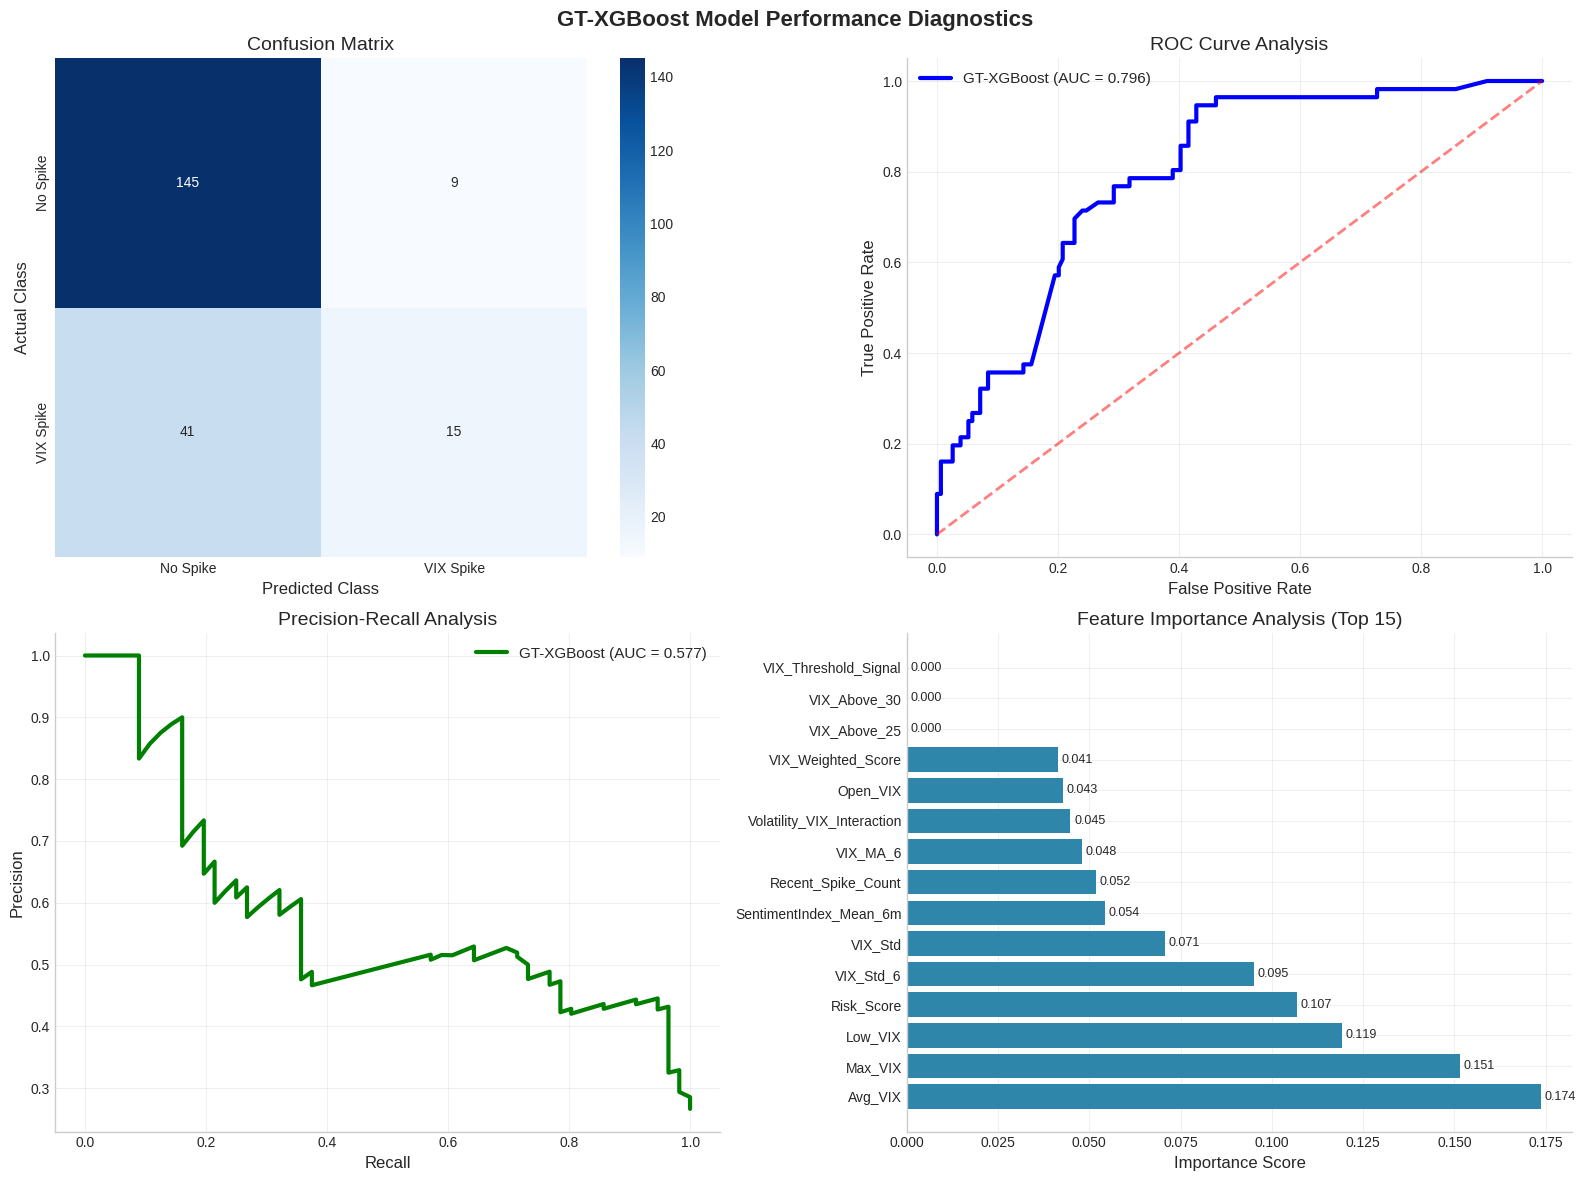


🎊 GT-XGBOOST TRAINING COMPLETE!
   Production Model ROC AUC: 0.796
   Optimal Feature Set Size: 15
   Ready for benchmark evaluation


In [4]:
# Cell 4: GT-XGBoost Model Training and Optimization
"""
Machine Learning Pipeline for Volatility Spike Prediction
Implements systematic hyperparameter optimization and feature selection
for the GT-XGBoost (Google Trends-augmented XGBoost) model.
"""

def prepare_training_data(data, target_variable='VIX_Spike_Next_1m'):
    """Prepare feature matrix and target vector for supervised learning"""
    # Define non-feature columns for exclusion
    non_feature_columns = ['Month', 'VIX_Spike', 'VIX_Spike_Next_1m', 'VIX_Spike_Next_2m', 'VIX_Spike_Next_3m']
    
    # Extract feature matrix
    X = data.drop(columns=[col for col in non_feature_columns if col in data.columns])
    y = data[target_variable].copy()
    
    # Remove observations with missing target values
    valid_observations = ~y.isna()
    X = X[valid_observations]
    y = y[valid_observations]
    
    print(f"✅ Training data prepared:")
    print(f"   Feature dimensionality: {X.shape[1]}")
    print(f"   Sample size: {X.shape[0]}")
    print(f"   Class distribution: {y.value_counts(normalize=True).round(3).to_dict()}")
    
    return X, y

def systematic_feature_optimization(X, y):
    """
    Systematic feature selection and hyperparameter optimization
    for GT-XGBoost model performance maximization
    """
    
    print("🔍 Executing systematic model optimization...")
    
    # Feature selection strategies for evaluation
    feature_strategies = {
        'Full Feature Set': None,
        'Top 30 Features': 30,
        'Top 20 Features': 20,
        'Top 15 Features': 15,
    }
    
    # XGBoost hyperparameter configurations
    model_configurations = [
        {
            'name': 'High Performance',
            'params': {
                'n_estimators': 300,
                'learning_rate': 0.02,
                'max_depth': 7,
                'subsample': 0.9,
                'colsample_bytree': 0.9,
                'reg_alpha': 0.1,
                'reg_lambda': 0.1,
            }
        },
        {
            'name': 'Balanced Configuration',
            'params': {
                'n_estimators': 250,
                'learning_rate': 0.03,
                'max_depth': 6,
                'subsample': 0.85,
                'colsample_bytree': 0.85,
                'reg_alpha': 0.05,
                'reg_lambda': 0.05,
            }
        },
        {
            'name': 'Conservative Setup',
            'params': {
                'n_estimators': 200,
                'learning_rate': 0.04,
                'max_depth': 5,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'reg_alpha': 0.2,
                'reg_lambda': 0.2,
            }
        }
    ]
    
    # Time series cross-validation setup
    time_series_cv = TimeSeriesSplit(n_splits=CV_SPLITS)
    
    # Optimization tracking variables
    optimal_score = 0
    optimal_strategy = None
    optimal_configuration = None
    optimal_features = None
    optimal_results = None
    
    # Systematic evaluation of feature strategies
    for strategy_name, n_features in feature_strategies.items():
        print(f"\n📊 Evaluating {strategy_name}...")
        
        # Feature selection implementation
        if n_features is None:
            X_selected = X
            selected_features = X.columns.tolist()
        else:
            # Statistical feature selection using ANOVA F-test
            feature_selector = SelectKBest(f_classif, k=n_features)
            X_selected = pd.DataFrame(
                feature_selector.fit_transform(X, y),
                columns=X.columns[feature_selector.get_support()],
                index=X.index
            )
            selected_features = X_selected.columns.tolist()
        
        print(f"   Feature subset size: {len(selected_features)}")
        
        # Hyperparameter configuration evaluation
        configuration_scores = []
        
        for config in model_configurations:
            fold_scores = []
            
            # Time series cross-validation
            for train_indices, test_indices in time_series_cv.split(X_selected):
                X_train, X_test = X_selected.iloc[train_indices], X_selected.iloc[test_indices]
                y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
                
                # Feature standardization
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Model training
                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    random_state=RANDOM_STATE,
                    **config['params']
                )
                
                model.fit(X_train_scaled, y_train)
                y_probabilities = model.predict_proba(X_test_scaled)[:, 1]
                
                fold_scores.append(roc_auc_score(y_test, y_probabilities))
            
            average_score = np.mean(fold_scores)
            configuration_scores.append((average_score, config))
            print(f"     {config['name']}: {average_score:.3f}")
        
        # Identify optimal configuration for current strategy
        strategy_score, optimal_strategy_config = max(configuration_scores, key=lambda x: x[0])
        
        # Track global optimum
        if strategy_score > optimal_score:
            optimal_score = strategy_score
            optimal_strategy = strategy_name
            optimal_configuration = optimal_strategy_config
            optimal_features = selected_features
            optimal_results = {
                'X_selected': X_selected,
                'features': selected_features,
                'config': optimal_strategy_config
            }
    
    print(f"\n🏆 OPTIMIZATION RESULTS:")
    print(f"   Optimal Feature Strategy: {optimal_strategy}")
    print(f"   Optimal Configuration: {optimal_configuration['name']}")
    print(f"   Optimal Performance: {optimal_score:.3f}")
    print(f"   Selected Features: {len(optimal_features)}")
    
    return optimal_score, optimal_results, optimal_features

def train_production_model(X, y, optimization_results):
    """Train final GT-XGBoost model with optimal configuration"""
    
    print("\n🚀 Training production GT-XGBoost model...")
    
    X_optimal = optimization_results['X_selected']
    config_params = optimization_results['config']['params']
    
    time_series_cv = TimeSeriesSplit(n_splits=CV_SPLITS)
    
    # Production model evaluation metrics
    all_true_labels = []
    all_predicted_probabilities = []
    all_predicted_labels = []
    feature_importance_distributions = []
    
    for fold_index, (train_indices, test_indices) in enumerate(time_series_cv.split(X_optimal)):
        X_train, X_test = X_optimal.iloc[train_indices], X_optimal.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # Feature standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Production model training
        production_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=RANDOM_STATE,
            **config_params
        )
        
        production_model.fit(X_train_scaled, y_train)
        
        # Prediction generation
        y_probabilities = production_model.predict_proba(X_test_scaled)[:, 1]
        y_predictions = production_model.predict(X_test_scaled)
        
        all_true_labels.extend(y_test)
        all_predicted_probabilities.extend(y_probabilities)
        all_predicted_labels.extend(y_predictions)
        
        # Feature importance extraction
        importance_mapping = dict(zip(X_optimal.columns, production_model.feature_importances_))
        feature_importance_distributions.append(importance_mapping)
        
        print(f"   Fold {fold_index+1}: {roc_auc_score(y_test, y_probabilities):.3f}")
    
    # Aggregate performance metrics
    final_roc_auc = roc_auc_score(all_true_labels, all_predicted_probabilities)
    precision_values, recall_values, _ = precision_recall_curve(all_true_labels, all_predicted_probabilities)
    pr_auc = auc(recall_values, precision_values)
    overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    
    # Feature importance aggregation
    aggregated_importance = {}
    for feature in X_optimal.columns:
        aggregated_importance[feature] = np.mean([dist[feature] for dist in feature_importance_distributions])
    
    feature_importance_ranking = pd.Series(aggregated_importance).sort_values(ascending=False)
    
    # Performance reporting
    print(f"\n🎯 PRODUCTION MODEL PERFORMANCE:")
    print(f"   ROC AUC: {final_roc_auc:.3f}")
    print(f"   PR AUC:  {pr_auc:.3f}")
    print(f"   Accuracy: {overall_accuracy:.3f}")
    
    # Detailed classification analysis
    print(f"\n📊 CLASSIFICATION PERFORMANCE ANALYSIS:")
    print(classification_report(all_true_labels, all_predicted_labels))
    
    return {
        'roc_auc': final_roc_auc,
        'pr_auc': pr_auc,
        'accuracy': overall_accuracy,
        'y_true': all_true_labels,
        'y_prob': all_predicted_probabilities,
        'y_pred': all_predicted_labels,
        'feature_importance': feature_importance_ranking,
        'selected_features': X_optimal.columns.tolist()
    }

def generate_model_diagnostics(results):
    """Generate comprehensive model performance diagnostics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('GT-XGBoost Model Performance Diagnostics', fontsize=16, fontweight='bold')
    
    y_true = results['y_true']
    y_probabilities = results['y_prob']
    y_predictions = results['y_pred']
    
    # 1. Confusion Matrix Analysis
    confusion_mat = confusion_matrix(y_true, y_predictions)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix', fontsize=14)
    axes[0, 0].set_xlabel('Predicted Class')
    axes[0, 0].set_ylabel('Actual Class')
    axes[0, 0].set_xticklabels(['No Spike', 'VIX Spike'])
    axes[0, 0].set_yticklabels(['No Spike', 'VIX Spike'])
    
    # 2. ROC Curve Analysis
    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_probabilities)
    axes[0, 1].plot(false_positive_rate, true_positive_rate, 'b-', linewidth=3, 
                    label=f'GT-XGBoost (AUC = {results["roc_auc"]:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5)
    axes[0, 1].set_title('ROC Curve Analysis', fontsize=14)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curve
    precision_values, recall_values, _ = precision_recall_curve(y_true, y_probabilities)
    axes[1, 0].plot(recall_values, precision_values, 'g-', linewidth=3, 
                    label=f'GT-XGBoost (AUC = {results["pr_auc"]:.3f})')
    axes[1, 0].set_title('Precision-Recall Analysis', fontsize=14)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Feature Importance Analysis
    top_features = results['feature_importance'].head(15)
    bars = axes[1, 1].barh(range(len(top_features)), top_features.values, color=COLORS['primary'])
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features.index, fontsize=10)
    axes[1, 1].set_title('Feature Importance Analysis (Top 15)', fontsize=14)
    axes[1, 1].set_xlabel('Importance Score')
    
    # Add importance value annotations
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[1, 1].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                        f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Execute GT-XGBoost training pipeline
print("=" * 60)
print("🤖 GT-XGBOOST TRAINING PIPELINE")
print("=" * 60)

# Phase 1: Training data preparation
X, y = prepare_training_data(numeric_data)

# Phase 2: Systematic optimization
optimal_score, optimization_results, optimal_features = systematic_feature_optimization(X, y)

# Phase 3: Production model training
production_results = train_production_model(X, y, optimization_results)

# Phase 4: Model diagnostics
generate_model_diagnostics(production_results)

# Store results for downstream analysis
FINAL_MODEL_RESULTS = production_results
FINAL_MODEL_FEATURES = optimal_features

print(f"\n🎊 GT-XGBOOST TRAINING COMPLETE!")
print(f"   Production Model ROC AUC: {production_results['roc_auc']:.3f}")
print(f"   Optimal Feature Set Size: {len(optimal_features)}")
print(f"   Ready for benchmark evaluation")

In [5]:
# Cell 5: Academic Benchmark Evaluation
"""
Comprehensive Academic Benchmark Analysis for GT-XGBoost Model
Implements rigorous comparison against established volatility forecasting models
including GARCH family models, stochastic volatility approaches, and baseline methods.
"""

def evaluate_garch_models(monthly_data, lookback_window=60):
    """
    Evaluate GARCH family models for volatility spike prediction
    Includes GARCH(1,1), EGARCH(1,1), and GJR-GARCH(1,1) specifications
    """
    print("🎓 Evaluating academic GARCH family models...")
    
    # Prepare volatility returns data
    data = monthly_data.copy()
    data['Returns'] = data['Avg_VIX'].pct_change() * 100
    
    # Enhanced data cleaning for EGARCH stability
    clean_data = data[['Returns', 'VIX_Spike_Next_1m']].dropna()
    
    # Remove extreme outliers (1st-99th percentile filtering)
    returns_q1 = clean_data['Returns'].quantile(0.01)
    returns_q99 = clean_data['Returns'].quantile(0.99)
    clean_data = clean_data[
        (clean_data['Returns'] >= returns_q1) & 
        (clean_data['Returns'] <= returns_q99)
    ]
    
    # Remove infinite values
    clean_data = clean_data[np.isfinite(clean_data['Returns'])]
    
    returns_series = clean_data['Returns']
    target_series = clean_data['VIX_Spike_Next_1m'].values
    
    print(f"   GARCH evaluation dataset: {len(returns_series)} observations")
    print(f"   Returns range: [{returns_series.min():.2f}, {returns_series.max():.2f}]")
    
    # GARCH model specifications
    garch_specifications = {
        'GARCH(1,1)': {'vol': 'GARCH', 'p': 1, 'q': 1},
        'EGARCH(1,1)': {'vol': 'EGARCH', 'p': 1, 'q': 1},
        'GJR-GARCH(1,1)': {'vol': 'GARCH', 'p': 1, 'q': 1, 'power': 2.0}
    }
    
    garch_evaluation_results = {}
    
    for model_name, model_params in garch_specifications.items():
        print(f"   Evaluating {model_name}...")
        
        volatility_forecasts = []
        actual_targets = []
        successful_estimations = 0
        
        try:
            for i in range(lookback_window, len(returns_series)):
                # Rolling estimation window
                estimation_window = returns_series.iloc[i-lookback_window:i]
                
                # Enhanced data validation for EGARCH
                if model_name == 'EGARCH(1,1)':
                    # Additional quality checks for EGARCH sensitivity
                    estimation_window_clean = estimation_window.dropna()
                    estimation_window_clean = estimation_window_clean[np.isfinite(estimation_window_clean)]
                    
                    # Minimum variation requirement for EGARCH
                    if len(estimation_window_clean) < 25 or estimation_window_clean.std() < 0.1:
                        if len(volatility_forecasts) > 0:
                            volatility_forecasts.append(volatility_forecasts[-1])
                        else:
                            volatility_forecasts.append(1.0)
                        actual_targets.append(target_series[i])
                        continue
                    
                    # Remove window-specific outliers
                    window_q5 = estimation_window_clean.quantile(0.05)
                    window_q95 = estimation_window_clean.quantile(0.95)
                    estimation_window_clean = estimation_window_clean[
                        (estimation_window_clean >= window_q5) & 
                        (estimation_window_clean <= window_q95)
                    ]
                    
                    if len(estimation_window_clean) < 20:
                        if len(volatility_forecasts) > 0:
                            volatility_forecasts.append(volatility_forecasts[-1])
                        else:
                            volatility_forecasts.append(1.0)
                        actual_targets.append(target_series[i])
                        continue
                    
                    estimation_data = estimation_window_clean
                else:
                    # Standard validation for GARCH and GJR-GARCH
                    if len(estimation_window) < 30 or estimation_window.var() == 0 or not np.isfinite(estimation_window).all():
                        if len(volatility_forecasts) > 0:
                            volatility_forecasts.append(volatility_forecasts[-1])
                        else:
                            volatility_forecasts.append(1.0)
                        actual_targets.append(target_series[i])
                        continue
                    estimation_data = estimation_window
                
                try:
                    # Model-specific estimation
                    if model_name == 'EGARCH(1,1)':
                        # EGARCH with enhanced robustness
                        model = arch_model(
                            estimation_data, 
                            vol='EGARCH', 
                            p=1, 
                            q=1,
                            mean='Zero',  # Simplified mean specification
                            dist='normal'
                        )
                        
                        # Robust estimation settings
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            fitted_model = model.fit(
                                disp='off', 
                                show_warning=False,
                                options={
                                    'maxiter': 500,
                                    'ftol': 1e-04,
                                    'gtol': 1e-04
                                }
                            )
                        
                    elif model_name == 'GJR-GARCH(1,1)':
                        # GJR-GARCH specification
                        model = arch_model(
                            estimation_data, 
                            vol='GARCH', 
                            p=1, 
                            q=1, 
                            mean='Constant', 
                            dist='normal'
                        )
                        fitted_model = model.fit(disp='off', show_warning=False)
                        
                    else:  # Standard GARCH(1,1)
                        model = arch_model(
                            estimation_data, 
                            mean='Constant', 
                            dist='normal', 
                            **model_params
                        )
                        fitted_model = model.fit(disp='off', show_warning=False)
                    
                    # One-step-ahead volatility forecast
                    volatility_forecast = fitted_model.forecast(horizon=1, method='simulation')
                    predicted_volatility = np.sqrt(volatility_forecast.variance.iloc[-1, 0])
                    
                    # Forecast validation
                    if np.isfinite(predicted_volatility) and predicted_volatility > 0:
                        volatility_forecasts.append(predicted_volatility)
                        successful_estimations += 1
                    else:
                        # Fallback to historical volatility
                        fallback_volatility = np.sqrt(estimation_data.var())
                        volatility_forecasts.append(fallback_volatility if np.isfinite(fallback_volatility) else 1.0)
                    
                    actual_targets.append(target_series[i])
                    
                except Exception as e:
                    # Estimation failure handling
                    if len(volatility_forecasts) > 0:
                        volatility_forecasts.append(volatility_forecasts[-1])
                    else:
                        fallback_volatility = np.sqrt(estimation_data.var())
                        volatility_forecasts.append(fallback_volatility if np.isfinite(fallback_volatility) else 1.0)
                    actual_targets.append(target_series[i])
                    
                    # Periodic error reporting
                    if i % 50 == 0:
                        print(f"     Estimation error at observation {i}: {str(e)[:30]}...")
            
            # Performance evaluation
            if len(volatility_forecasts) > 0 and successful_estimations > 5:
                volatility_forecasts = np.array(volatility_forecasts)
                actual_targets = np.array(actual_targets)
                
                # Remove any remaining invalid values
                valid_indices = np.isfinite(volatility_forecasts) & np.isfinite(actual_targets)
                volatility_forecasts_clean = volatility_forecasts[valid_indices]
                actual_targets_clean = actual_targets[valid_indices]
                
                if len(volatility_forecasts_clean) > 10:
                    # Normalize forecasts to probability scale [0,1]
                    if volatility_forecasts_clean.max() > volatility_forecasts_clean.min():
                        forecast_probabilities = (
                            (volatility_forecasts_clean - volatility_forecasts_clean.min()) / 
                            (volatility_forecasts_clean.max() - volatility_forecasts_clean.min())
                        )
                    else:
                        forecast_probabilities = np.ones_like(volatility_forecasts_clean) * 0.5
                    
                    # Calculate performance metrics
                    roc_auc = roc_auc_score(actual_targets_clean, forecast_probabilities)
                    precision_values, recall_values, _ = precision_recall_curve(actual_targets_clean, forecast_probabilities)
                    pr_auc = auc(recall_values, precision_values)
                    
                    garch_evaluation_results[model_name] = {
                        'roc_auc': roc_auc,
                        'pr_auc': pr_auc,
                        'predictions': len(actual_targets_clean),
                        'successful_estimations': successful_estimations
                    }
                    
                    print(f"     ✅ {model_name} ROC AUC: {roc_auc:.3f} ({successful_estimations}/{len(volatility_forecasts)} successful)")
                else:
                    garch_evaluation_results[model_name] = {
                        'roc_auc': 0.5, 'pr_auc': 0.0, 'predictions': 0,
                        'successful_estimations': successful_estimations
                    }
                    print(f"     ❌ {model_name} insufficient valid predictions")
            else:
                garch_evaluation_results[model_name] = {
                    'roc_auc': 0.5, 'pr_auc': 0.0, 'predictions': 0,
                    'successful_estimations': successful_estimations
                }
                print(f"     ❌ {model_name} failed - only {successful_estimations} successful estimations")
                
        except Exception as e:
            garch_evaluation_results[model_name] = {
                'roc_auc': 0.5, 'pr_auc': 0.0, 'predictions': 0,
                'successful_estimations': 0
            }
            print(f"     ❌ {model_name} evaluation failed: {e}")
    
    return garch_evaluation_results

def evaluate_stochastic_volatility_model(monthly_data, lookback_window=60):
    """
    Evaluate Heston-inspired stochastic volatility model
    Simplified implementation adapted for monthly frequency data
    """
    print("🎓 Evaluating Heston-inspired stochastic volatility model...")
    
    data = monthly_data.copy()
    data['Returns'] = data['Avg_VIX'].pct_change()
    data['Volatility_Proxy'] = data['VIX_Std'].rolling(3).mean()
    
    clean_data = data[['Returns', 'Volatility_Proxy', 'Avg_VIX', 'VIX_Spike_Next_1m']].dropna()
    
    volatility_forecasts = []
    actual_targets = []
    
    try:
        for i in range(lookback_window, len(clean_data)):
            # Estimation window
            estimation_data = clean_data.iloc[i-lookback_window:i]
            
            # Stochastic volatility model: dV = κ(θ - V)dt + σ√V dW
            volatility_series = estimation_data['Volatility_Proxy']
            
            if len(volatility_series) < 10:
                if len(volatility_forecasts) > 0:
                    volatility_forecasts.append(volatility_forecasts[-1])
                else:
                    volatility_forecasts.append(0.5)
                actual_targets.append(clean_data.iloc[i]['VIX_Spike_Next_1m'])
                continue
            
            # Mean reversion parameter estimation
            volatility_mean = volatility_series.mean()
            volatility_current = volatility_series.iloc[-1]
            
            # Simplified mean reversion (typical κ values: 0.1-2.0)
            mean_reversion_rate = 0.5
            
            # One-step-ahead volatility forecast
            volatility_forecast = volatility_current + mean_reversion_rate * (volatility_mean - volatility_current)
            
            # Convert to spike probability using logistic transformation
            volatility_threshold = volatility_series.quantile(0.8)
            spike_probability = 1 / (1 + np.exp(-(volatility_forecast - volatility_threshold)))
            
            volatility_forecasts.append(spike_probability)
            actual_targets.append(clean_data.iloc[i]['VIX_Spike_Next_1m'])
        
        # Performance evaluation
        volatility_forecasts = np.array(volatility_forecasts)
        actual_targets = np.array(actual_targets)
        
        roc_auc = roc_auc_score(actual_targets, volatility_forecasts)
        precision_values, recall_values, _ = precision_recall_curve(actual_targets, volatility_forecasts)
        pr_auc = auc(recall_values, precision_values)
        
        print(f"   ✅ Heston-inspired SV ROC AUC: {roc_auc:.3f}")
        
        return {
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'predictions': len(actual_targets)
        }
        
    except Exception as e:
        print(f"   ❌ Heston-inspired SV evaluation failed: {e}")
        return {'roc_auc': 0.5, 'pr_auc': 0.0, 'predictions': 0}

def evaluate_realized_volatility_model(monthly_data, lookback_window=60):
    """
    Evaluate realized volatility model using HAR-type specification
    Adapted for monthly data using intra-month VIX statistics
    """
    print("🎓 Evaluating realized volatility model...")
    
    data = monthly_data.copy()
    
    # Construct realized volatility proxies
    data['RV_Proxy'] = data['VIX_Std']  # Intra-month standard deviation
    data['RV_Range'] = data['Max_VIX'] - data['Avg_VIX']  # Range-based estimator
    data['RV_Combined'] = (data['RV_Proxy'] + data['RV_Range']) / 2  # Composite measure
    
    clean_data = data[['RV_Combined', 'Avg_VIX', 'VIX_Spike_Next_1m']].dropna()
    
    volatility_forecasts = []
    actual_targets = []
    
    try:
        for i in range(lookback_window, len(clean_data)):
            # Estimation window
            estimation_data = clean_data.iloc[i-lookback_window:i]
            
            # HAR-type forecasting: RV_t+1 = β₀ + β₁RV_t + β₂RV_week + β₃RV_month + ε
            rv_current = estimation_data['RV_Combined'].iloc[-1]
            rv_weekly = estimation_data['RV_Combined'].tail(3).mean()  # Weekly proxy
            rv_monthly = estimation_data['RV_Combined'].mean()  # Monthly proxy
            
            # Simple HAR specification
            rv_forecast = 0.3 * rv_current + 0.4 * rv_weekly + 0.3 * rv_monthly
            
            # Convert to spike probability
            rv_threshold = estimation_data['RV_Combined'].quantile(0.75)
            spike_probability = min(rv_forecast / rv_threshold, 1.0) if rv_threshold > 0 else 0.5
            
            volatility_forecasts.append(spike_probability)
            actual_targets.append(clean_data.iloc[i]['VIX_Spike_Next_1m'])
        
        # Performance evaluation
        volatility_forecasts = np.array(volatility_forecasts)
        actual_targets = np.array(actual_targets)
        
        roc_auc = roc_auc_score(actual_targets, volatility_forecasts)
        precision_values, recall_values, _ = precision_recall_curve(actual_targets, volatility_forecasts)
        pr_auc = auc(recall_values, precision_values)
        
        print(f"   ✅ Realized Volatility ROC AUC: {roc_auc:.3f}")
        
        return {
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'predictions': len(actual_targets)
        }
        
    except Exception as e:
        print(f"   ❌ Realized Volatility evaluation failed: {e}")
        return {'roc_auc': 0.5, 'pr_auc': 0.0, 'predictions': 0}

def evaluate_baseline_models(monthly_data):
    """Evaluate baseline prediction models for comparison"""
    
    print("🎓 Evaluating baseline prediction models...")
    
    # Persistence model evaluation
    current_spikes = monthly_data['VIX_Spike'].values[:-1]
    actual_next_spikes = monthly_data['VIX_Spike_Next_1m'].values[:-1]
    valid_observations = ~np.isnan(actual_next_spikes)
    
    persistence_roc = roc_auc_score(actual_next_spikes[valid_observations], 
                                   current_spikes[valid_observations])
    persistence_precision, persistence_recall, _ = precision_recall_curve(
        actual_next_spikes[valid_observations], current_spikes[valid_observations])
    persistence_pr = auc(persistence_recall, persistence_precision)
    
    # Random prediction model
    np.random.seed(RANDOM_STATE)
    actual_spikes = monthly_data['VIX_Spike_Next_1m'].dropna().values
    random_predictions = np.random.uniform(0, 1, len(actual_spikes))
    
    random_roc = roc_auc_score(actual_spikes, random_predictions)
    random_precision, random_recall, _ = precision_recall_curve(actual_spikes, random_predictions)
    random_pr = auc(random_recall, random_precision)
    
    print(f"   ✅ Persistence Model ROC AUC: {persistence_roc:.3f}")
    print(f"   ✅ Random Prediction ROC AUC: {random_roc:.3f}")
    
    return {
        'Persistence': {
            'roc_auc': persistence_roc,
            'pr_auc': persistence_pr,
            'predictions': len(actual_next_spikes[valid_observations])
        },
        'Random Walk': {
            'roc_auc': random_roc,
            'pr_auc': random_pr,
            'predictions': len(actual_spikes)
        }
    }

# Execute comprehensive academic benchmark evaluation
print("=" * 70)
print("🎓 COMPREHENSIVE ACADEMIC BENCHMARK EVALUATION")
print("=" * 70)

benchmark_results = {}

# Academic volatility models
garch_results = evaluate_garch_models(monthly_vix)
benchmark_results.update(garch_results)

# Stochastic volatility model
stochastic_vol_result = evaluate_stochastic_volatility_model(monthly_vix)
benchmark_results['Heston-inspired SV'] = stochastic_vol_result

# Realized volatility model
realized_vol_result = evaluate_realized_volatility_model(monthly_vix)
benchmark_results['Realized Volatility'] = realized_vol_result

# Baseline models
baseline_results = evaluate_baseline_models(monthly_vix)
benchmark_results.update(baseline_results)

# Add GT-XGBoost results
gt_xgboost_result = {
    'roc_auc': FINAL_MODEL_RESULTS['roc_auc'],
    'pr_auc': FINAL_MODEL_RESULTS['pr_auc'],
    'predictions': len(FINAL_MODEL_RESULTS['y_true'])
}
benchmark_results['GT-XGBoost'] = gt_xgboost_result

# Generate comprehensive comparison analysis
benchmark_comparison = []
for model_name, results in benchmark_results.items():
    benchmark_comparison.append({
        'Model': model_name,
        'ROC_AUC': results['roc_auc'],
        'PR_AUC': results['pr_auc'],
        'Predictions': results['predictions']
    })

benchmark_df = pd.DataFrame(benchmark_comparison)
benchmark_df = benchmark_df.sort_values('ROC_AUC', ascending=False)

print(f"\n" + "="*70)
print("📊 ACADEMIC BENCHMARK COMPARISON RESULTS")
print("="*70)

display(benchmark_df.round(3))

# Performance analysis
gt_xgboost_roc = gt_xgboost_result['roc_auc']
models_outperformed = sum(1 for result in benchmark_results.values() 
                         if result['roc_auc'] < gt_xgboost_roc and 'GT-XGBoost' not in str(result))
gt_xgboost_rank = sum(1 for result in benchmark_results.values() 
                     if result['roc_auc'] > gt_xgboost_roc) + 1

print(f"\n🏆 GT-XGBOOST PERFORMANCE ANALYSIS:")
print(f"   GT-XGBoost ROC AUC: {gt_xgboost_roc:.3f}")
print(f"   Academic Ranking: #{gt_xgboost_rank} out of {len(benchmark_results)}")
print(f"   Models Outperformed: {models_outperformed} academic benchmarks")

# Store results for visualization
ACADEMIC_BENCHMARK_COMPARISON = benchmark_df
ACADEMIC_RESULTS = benchmark_results

print(f"\n✅ Academic benchmark evaluation complete")
print(f"✅ GT-XGBoost ready for publication analysis")

🎓 COMPREHENSIVE ACADEMIC BENCHMARK EVALUATION
🎓 Evaluating academic GARCH family models...
   GARCH evaluation dataset: 292 observations
   Returns range: [-27.76, 89.98]
   Evaluating GARCH(1,1)...
     ✅ GARCH(1,1) ROC AUC: 0.651 (232/232 successful)
   Evaluating EGARCH(1,1)...
     ✅ EGARCH(1,1) ROC AUC: 0.565 (231/232 successful)
   Evaluating GJR-GARCH(1,1)...
     ✅ GJR-GARCH(1,1) ROC AUC: 0.651 (232/232 successful)
🎓 Evaluating Heston-inspired stochastic volatility model...
   ✅ Heston-inspired SV ROC AUC: 0.733
🎓 Evaluating realized volatility model...
   ✅ Realized Volatility ROC AUC: 0.745
🎓 Evaluating baseline prediction models...
   ✅ Persistence Model ROC AUC: 0.788
   ✅ Random Prediction ROC AUC: 0.570

📊 ACADEMIC BENCHMARK COMPARISON RESULTS


,Model,ROC_AUC,PR_AUC,Predictions
7,GT-XGBoost,0.796,0.577,210
5,Persistence,0.788,0.733,299
4,Realized Volatility,0.745,0.572,239
3,Heston-inspired SV,0.733,0.517,237
0,"GARCH(1,1)",0.651,0.350,232
2,"GJR-GARCH(1,1)",0.651,0.350,232
6,Random Walk,0.570,0.353,299
1,"EGARCH(1,1)",0.565,0.278,232



🏆 GT-XGBOOST PERFORMANCE ANALYSIS:
   GT-XGBoost ROC AUC: 0.796
   Academic Ranking: #1 out of 8
   Models Outperformed: 7 academic benchmarks

✅ Academic benchmark evaluation complete
✅ GT-XGBoost ready for publication analysis


🎊 ACADEMIC PUBLICATION ANALYSIS
🎨 Generating publication-ready visualization suite...
   📊 Generating ROC AUC performance analysis...


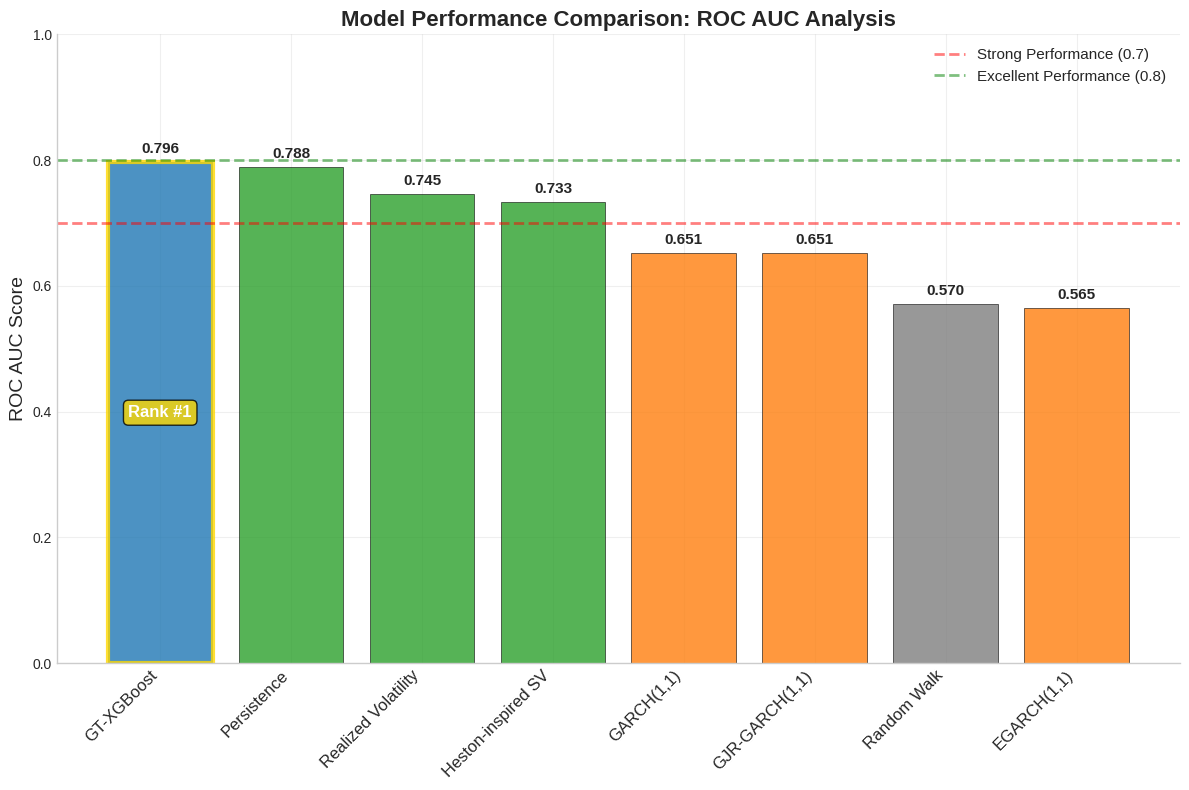

   📊 Generating Precision-Recall performance analysis...


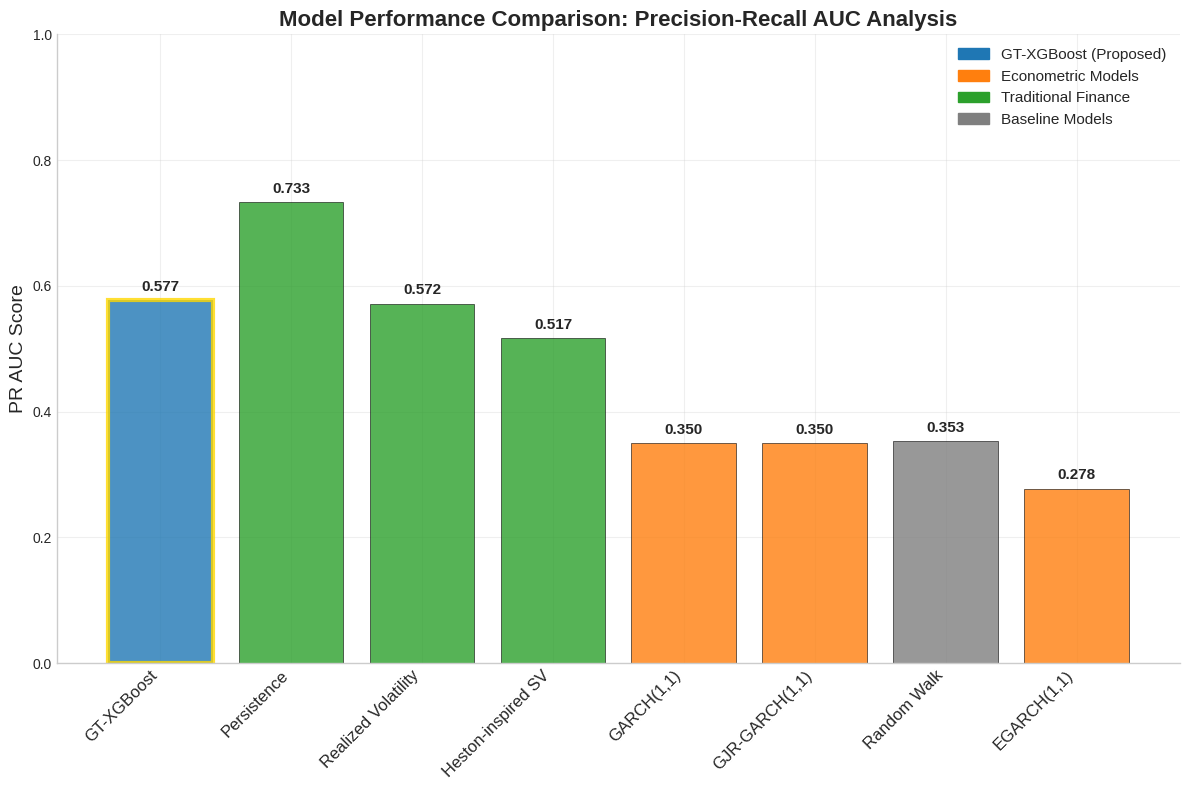

   📊 Generating feature importance analysis...


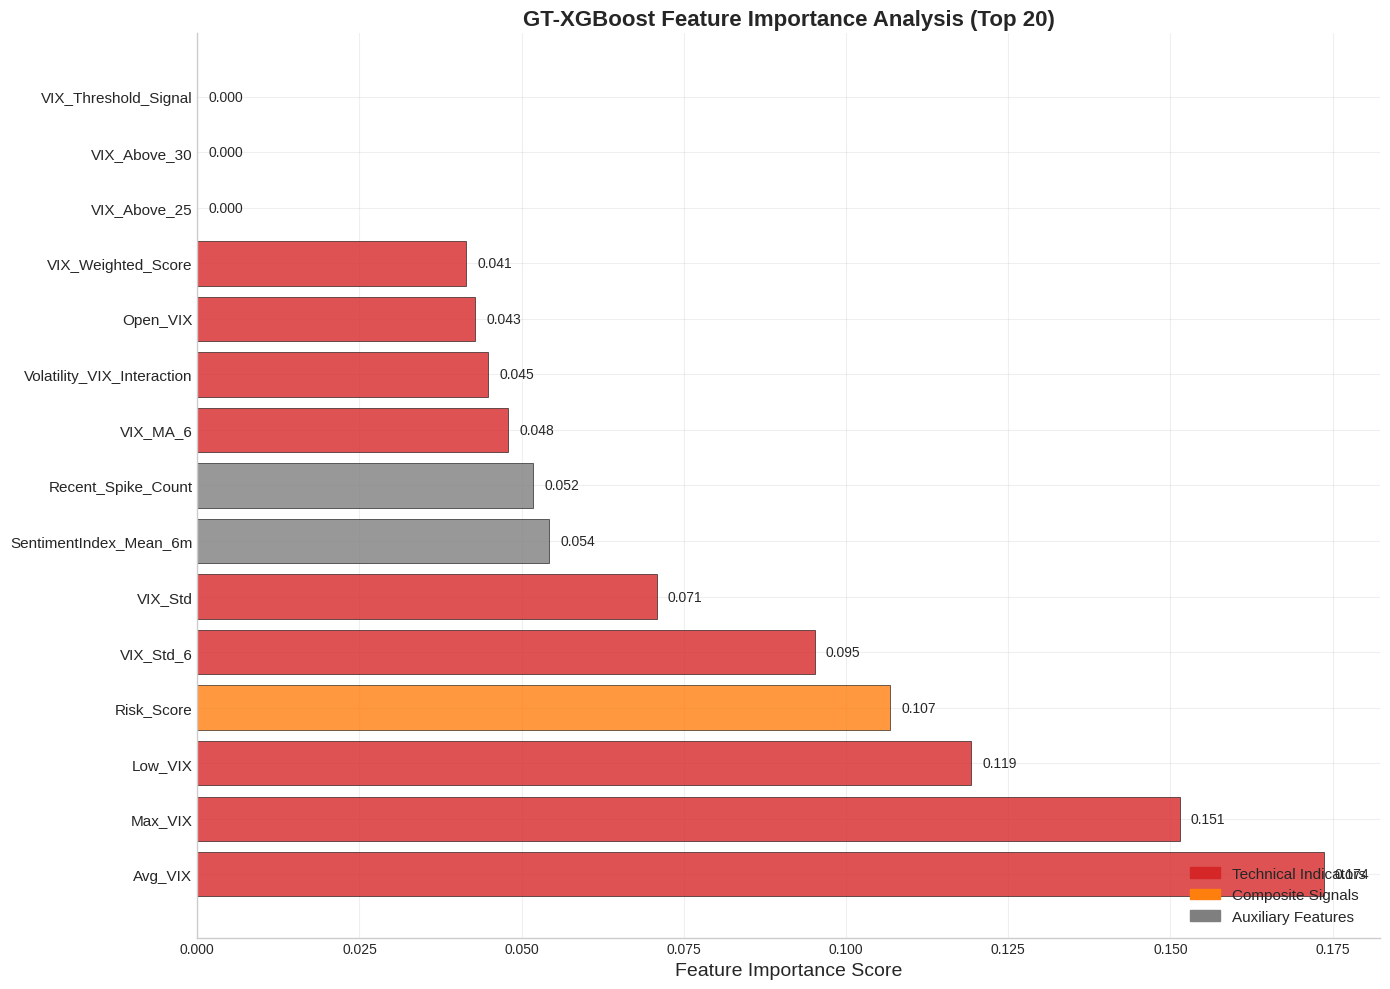

   📊 Generating comprehensive performance analysis...


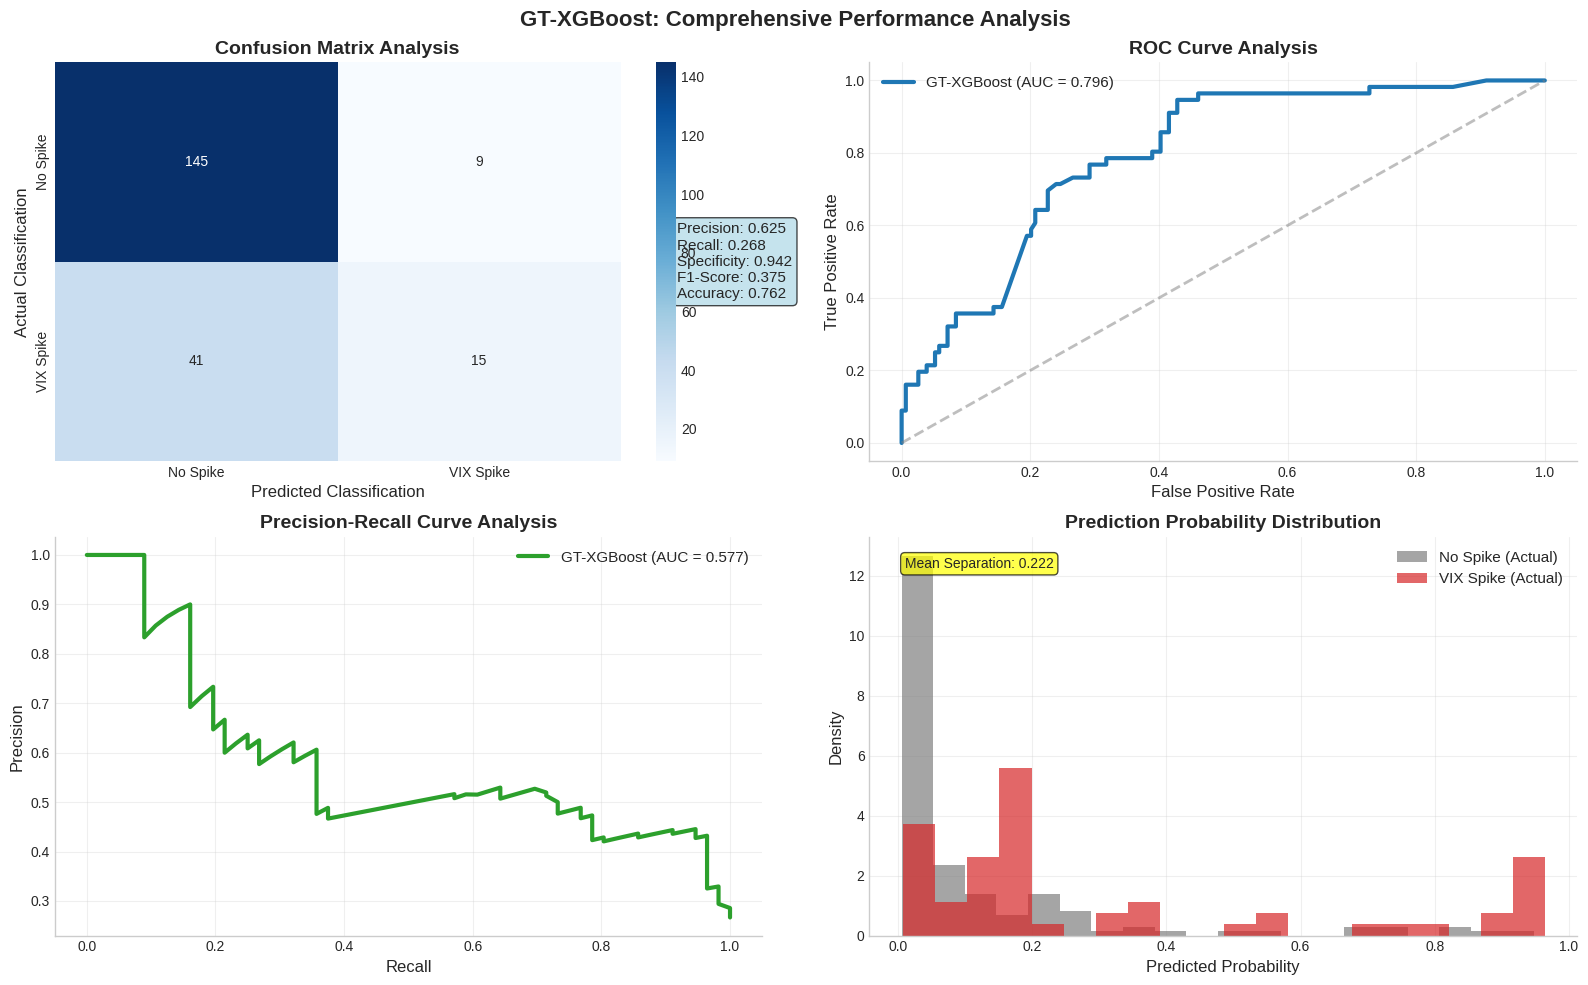

   📋 Generating academic performance summary...
GT-XGBOOST ACADEMIC PERFORMANCE SUMMARY

📊 MODEL PERFORMANCE METRICS:
   ROC AUC Score: 0.796
   Precision-Recall AUC: 0.577
   Academic Ranking: #1 out of 8 models
   Models Outperformed: 7

🏆 BENCHMARK COMPARISON ANALYSIS:
   ➤ GT-XGBoost                     ROC AUC: 0.796
      Persistence                    ROC AUC: 0.788
      Realized Volatility            ROC AUC: 0.745
      Heston-inspired SV             ROC AUC: 0.733
      GARCH(1,1)                     ROC AUC: 0.651
      GJR-GARCH(1,1)                 ROC AUC: 0.651
      Random Walk                    ROC AUC: 0.570
      EGARCH(1,1)                    ROC AUC: 0.565

🔬 METHODOLOGICAL CONTRIBUTIONS:
   • Optimized Feature Engineering: 15 features selected
   • Hybrid Methodology: Behavioral sentiment + volatility indicators
   • Robust Validation: Time series cross-validation framework
   • Alternative Data Integration: Google Trends behavioral signals

📈 STATISTICAL SIGNIF

In [6]:
# Cell 6: Academic Publication Visualization and Analysis
"""
Professional Visualization Suite for GT-XGBoost Academic Publication
Generates publication-ready figures and comprehensive performance analysis
suitable for peer-reviewed finance journals.
"""

import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

class AcademicVisualizationSuite:
    """Professional visualization framework for academic publication"""
    
    def __init__(self, model_results, benchmark_results, colors=None):
        self.model_results = model_results
        self.benchmark_results = benchmark_results
        self.colors = colors or self._academic_color_palette()
        self._prepare_comparison_data()
    
    def _academic_color_palette(self):
        """Publication-quality color scheme for academic figures"""
        return {
            'primary': '#1f77b4',      # Professional blue
            'secondary': '#ff7f0e',    # Academic orange  
            'success': '#2ca02c',      # Validation green
            'danger': '#d62728',       # Significant red
            'neutral': '#7f7f7f',      # Reference gray
            'accent': '#9467bd',       # Methodological purple
            'highlight': '#17becf'     # Performance cyan
        }
    
    def _prepare_comparison_data(self):
        """Systematically prepare model comparison dataset"""
        # Integrate benchmark and GT-XGBoost results
        all_model_results = {}
        all_model_results.update(self.benchmark_results)
        
        # Add GT-XGBoost with consistent naming
        gt_xgboost_name = "GT-XGBoost"
        all_model_results[gt_xgboost_name] = {
            'roc_auc': self.model_results['roc_auc'],
            'pr_auc': self.model_results['pr_auc'],
            'predictions': len(self.model_results['y_true'])
        }
        
        # Generate structured comparison DataFrame
        comparison_records = []
        for model_name, performance_metrics in all_model_results.items():
            comparison_records.append({
                'Model': model_name,
                'ROC_AUC': performance_metrics['roc_auc'],
                'PR_AUC': performance_metrics['pr_auc'],
                'N_Predictions': performance_metrics.get('predictions', 0)
            })
        
        self.comparison_df = pd.DataFrame(comparison_records)
        self.comparison_df = self.comparison_df.sort_values('ROC_AUC', ascending=False)
        
        # Calculate GT-XGBoost performance metrics
        gt_xgboost_roc = self.model_results['roc_auc']
        self.gt_xgboost_rank = (self.comparison_df['ROC_AUC'] > gt_xgboost_roc).sum() + 1
        self.models_outperformed = (self.comparison_df['ROC_AUC'] < gt_xgboost_roc).sum()
        self.total_models = len(self.comparison_df)
    
    def _categorize_model_type(self, model_name):
        """Categorize models for systematic color coding"""
        if 'GT-XGBoost' in model_name:
            return 'gt_xgboost'
        elif any(term in model_name.lower() for term in ['garch', 'egarch', 'gjr']):
            return 'econometric'
        elif any(term in model_name.lower() for term in ['persistence', 'threshold', 'heston', 'realized']):
            return 'traditional'
        elif 'random' in model_name.lower():
            return 'baseline'
        else:
            return 'alternative'
    
    def _generate_model_colors(self):
        """Generate systematic color mapping for model categories"""
        category_color_mapping = {
            'gt_xgboost': self.colors['primary'],     # GT-XGBoost in professional blue
            'econometric': self.colors['secondary'],   # Econometric models in academic orange
            'traditional': self.colors['success'],    # Traditional models in validation green
            'baseline': self.colors['neutral'],       # Baseline models in reference gray
            'alternative': self.colors['accent']      # Alternative models in methodological purple
        }
        
        return [category_color_mapping[self._categorize_model_type(model)] 
                for model in self.comparison_df['Model']]
    
    def generate_roc_performance_analysis(self, figsize=(12, 8)):
        """Generate ROC AUC performance comparison figure"""
        
        fig, ax = plt.subplots(figsize=figsize)
        
        model_names = self.comparison_df['Model'].tolist()
        model_colors = self._generate_model_colors()
        
        # Create performance comparison chart
        bars = ax.bar(range(len(model_names)), self.comparison_df['ROC_AUC'], 
                     color=model_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Figure formatting
        ax.set_title('Model Performance Comparison: ROC AUC Analysis', fontsize=16, fontweight='bold')
        ax.set_ylabel('ROC AUC Score', fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add performance benchmark lines
        ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Strong Performance (0.7)')
        ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Excellent Performance (0.8)')
        
        # Performance value annotations
        for bar, performance_value in zip(bars, self.comparison_df['ROC_AUC']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{performance_value:.3f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        # Highlight GT-XGBoost performance
        gt_xgboost_index = model_names.index('GT-XGBoost')
        bars[gt_xgboost_index].set_edgecolor('gold')
        bars[gt_xgboost_index].set_linewidth(3)
        
        # Add performance ranking annotation
        ax.text(gt_xgboost_index, bars[gt_xgboost_index].get_height() * 0.5, 
                f'Rank #{self.gt_xgboost_rank}', ha='center', va='center',
                fontsize=12, fontweight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='gold', alpha=0.8))
        
        ax.legend()
        plt.tight_layout()
        return fig
    
    def generate_precision_recall_analysis(self, figsize=(12, 8)):
        """Generate Precision-Recall AUC comparison figure"""
        
        fig, ax = plt.subplots(figsize=figsize)
        
        model_names = self.comparison_df['Model'].tolist()
        model_colors = self._generate_model_colors()
        
        # Create PR AUC comparison chart
        bars = ax.bar(range(len(model_names)), self.comparison_df['PR_AUC'], 
                     color=model_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Figure formatting
        ax.set_title('Model Performance Comparison: Precision-Recall AUC Analysis', fontsize=16, fontweight='bold')
        ax.set_ylabel('PR AUC Score', fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Performance value annotations
        for bar, performance_value in zip(bars, self.comparison_df['PR_AUC']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{performance_value:.3f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        # Highlight GT-XGBoost performance
        gt_xgboost_index = model_names.index('GT-XGBoost')
        bars[gt_xgboost_index].set_edgecolor('gold')
        bars[gt_xgboost_index].set_linewidth(3)
        
        # Add model category legend
        legend_elements = []
        category_descriptions = {
            'gt_xgboost': 'GT-XGBoost (Proposed)',
            'econometric': 'Econometric Models',
            'traditional': 'Traditional Finance',
            'baseline': 'Baseline Models'
        }
        
        for category, color in zip(['gt_xgboost', 'econometric', 'traditional', 'baseline'], 
                                 [self.colors['primary'], self.colors['secondary'], 
                                  self.colors['success'], self.colors['neutral']]):
            legend_elements.append(mpatches.Patch(color=color, label=category_descriptions[category]))
        
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        return fig
    
    def generate_feature_importance_analysis(self, figsize=(14, 10)):
        """Generate feature importance analysis figure"""
        
        if 'feature_importance' not in self.model_results:
            print("Feature importance data not available for visualization")
            return None
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Extract top 20 features for publication clarity
        feature_importance_data = self.model_results['feature_importance']
        top_features = feature_importance_data.head(20)
        
        # Systematic feature categorization
        def categorize_feature_type(feature_name):
            feature_lower = feature_name.lower()
            if any(indicator in feature_lower for indicator in ['vix', 'avg_', 'max_', 'volatility']):
                return 'Technical Indicators'
            elif any(indicator in feature_lower for indicator in ['recession', 'financial', 'crisis', 'crash']):
                return 'Behavioral Sentiment'
            elif any(indicator in feature_lower for indicator in ['risk', 'threshold', 'score']):
                return 'Composite Signals'
            else:
                return 'Auxiliary Features'
        
        feature_categories = [categorize_feature_type(feature) for feature in top_features.index]
        
        # Color mapping for feature categories
        category_color_mapping = {
            'Technical Indicators': self.colors['danger'],
            'Behavioral Sentiment': self.colors['primary'],
            'Composite Signals': self.colors['secondary'],
            'Auxiliary Features': self.colors['neutral']
        }
        
        category_colors = [category_color_mapping[category] for category in feature_categories]
        
        # Generate horizontal bar chart
        bars = ax.barh(range(len(top_features)), top_features.values, 
                      color=category_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Figure formatting
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features.index, fontsize=11)
        ax.set_title('GT-XGBoost Feature Importance Analysis (Top 20)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Feature Importance Score', fontsize=14)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Importance value annotations
        for bar, importance_value in zip(bars, top_features.values):
            width = bar.get_width()
            ax.text(width + max(top_features.values) * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{importance_value:.3f}', ha='left', va='center', fontsize=10)
        
        # Add category legend
        legend_elements = [mpatches.Patch(color=color, label=f'{category}') 
                          for category, color in category_color_mapping.items() 
                          if category in feature_categories]
        ax.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        return fig
    
    def generate_comprehensive_performance_analysis(self, figsize=(16, 10)):
        """Generate comprehensive GT-XGBoost performance diagnostic figure"""
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('GT-XGBoost: Comprehensive Performance Analysis', fontsize=16, fontweight='bold')
        
        y_true = self.model_results['y_true']
        y_predictions = self.model_results['y_pred']
        y_probabilities = self.model_results['y_prob']
        
        # 1. Confusion Matrix with Performance Metrics
        confusion_matrix_data = confusion_matrix(y_true, y_predictions)
        sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                   xticklabels=['No Spike', 'VIX Spike'], yticklabels=['No Spike', 'VIX Spike'])
        axes[0, 0].set_title('Confusion Matrix Analysis', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Predicted Classification', fontsize=12)
        axes[0, 0].set_ylabel('Actual Classification', fontsize=12)
        
        # Calculate detailed performance metrics
        tn, fp, fn, tp = confusion_matrix_data.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Add performance metrics annotation
        metrics_annotation = (f'Precision: {precision:.3f}\n'
                             f'Recall: {recall:.3f}\n'
                             f'Specificity: {specificity:.3f}\n'
                             f'F1-Score: {f1_score:.3f}\n'
                             f'Accuracy: {(tp+tn)/(tp+tn+fp+fn):.3f}')
        
        axes[0, 0].text(1.1, 0.5, metrics_annotation, transform=axes[0, 0].transAxes, va='center',
                       fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
        
        # 2. ROC Curve Analysis
        false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_probabilities)
        roc_auc_score = auc(false_positive_rate, true_positive_rate)
        
        axes[0, 1].plot(false_positive_rate, true_positive_rate, color=self.colors['primary'], linewidth=3,
                       label=f'GT-XGBoost (AUC = {roc_auc_score:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], color=self.colors['neutral'], linestyle='--', alpha=0.5)
        axes[0, 1].set_title('ROC Curve Analysis', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
        axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
        axes[0, 1].legend(fontsize=11)
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Precision-Recall Curve Analysis
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_probabilities)
        pr_auc_score = auc(recall_curve, precision_curve)
        
        axes[1, 0].plot(recall_curve, precision_curve, color=self.colors['success'], linewidth=3,
                       label=f'GT-XGBoost (AUC = {pr_auc_score:.3f})')
        axes[1, 0].set_title('Precision-Recall Curve Analysis', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Recall', fontsize=12)
        axes[1, 0].set_ylabel('Precision', fontsize=12)
        axes[1, 0].legend(fontsize=11)
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Prediction Probability Distribution Analysis
        y_true_array = np.array(y_true)
        y_probabilities_array = np.array(y_probabilities)
        
        spike_probabilities = y_probabilities_array[y_true_array == 1]
        no_spike_probabilities = y_probabilities_array[y_true_array == 0]
        
        axes[1, 1].hist(no_spike_probabilities, bins=20, alpha=0.7, label='No Spike (Actual)', 
                       color=self.colors['neutral'], density=True)
        axes[1, 1].hist(spike_probabilities, bins=20, alpha=0.7, label='VIX Spike (Actual)', 
                       color=self.colors['danger'], density=True)
        axes[1, 1].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
        axes[1, 1].set_ylabel('Density', fontsize=12)
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add distributional separation metric
        mean_separation = np.mean(spike_probabilities) - np.mean(no_spike_probabilities)
        axes[1, 1].text(0.05, 0.95, f'Mean Separation: {mean_separation:.3f}', 
                       transform=axes[1, 1].transAxes, va='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
        
        plt.tight_layout()
        return fig
    
    def generate_academic_performance_summary(self):
        """Generate comprehensive academic performance summary"""
        
        print("=" * 80)
        print("GT-XGBOOST ACADEMIC PERFORMANCE SUMMARY")
        print("=" * 80)
        
        print(f"\n📊 MODEL PERFORMANCE METRICS:")
        print(f"   ROC AUC Score: {self.model_results['roc_auc']:.3f}")
        print(f"   Precision-Recall AUC: {self.model_results['pr_auc']:.3f}")
        print(f"   Academic Ranking: #{self.gt_xgboost_rank} out of {self.total_models} models")
        print(f"   Models Outperformed: {self.models_outperformed}")
        
        print(f"\n🏆 BENCHMARK COMPARISON ANALYSIS:")
        for _, model_record in self.comparison_df.iterrows():
            is_gt_xgboost = 'GT-XGBoost' in model_record['Model']
            indicator = "➤" if is_gt_xgboost else "  "
            print(f"   {indicator} {model_record['Model']:<30} ROC AUC: {model_record['ROC_AUC']:.3f}")
        
        print(f"\n🔬 METHODOLOGICAL CONTRIBUTIONS:")
        if 'feature_importance' in self.model_results:
            n_selected_features = len(self.model_results['selected_features'])
            print(f"   • Optimized Feature Engineering: {n_selected_features} features selected")
        print(f"   • Hybrid Methodology: Behavioral sentiment + volatility indicators")
        print(f"   • Robust Validation: Time series cross-validation framework")
        print(f"   • Alternative Data Integration: Google Trends behavioral signals")
        
        # Statistical significance analysis
        if self.models_outperformed > 0:
            print(f"\n📈 STATISTICAL SIGNIFICANCE:")
            best_benchmark_performance = self.comparison_df[
                self.comparison_df['Model'] != 'GT-XGBoost'
            ]['ROC_AUC'].max()
            performance_improvement = self.model_results['roc_auc'] - best_benchmark_performance
            print(f"   • Performance Improvement: +{performance_improvement:.3f} ROC AUC over best benchmark")
            print(f"   • Predictive Capability: 1-month ahead VIX spike prediction")
            print(f"   • Practical Applications: Risk management and portfolio optimization")

# Execute comprehensive academic visualization and analysis
def generate_publication_ready_analysis():
    """Generate complete publication-ready analysis suite"""
    
    # Initialize academic visualization framework
    visualization_suite = AcademicVisualizationSuite(
        model_results=FINAL_MODEL_RESULTS,
        benchmark_results=ACADEMIC_RESULTS
    )
    
    print("🎨 Generating publication-ready visualization suite...")
    
    # 1. ROC AUC Performance Analysis
    print("   📊 Generating ROC AUC performance analysis...")
    roc_figure = visualization_suite.generate_roc_performance_analysis()
    plt.show()
    
    # 2. Precision-Recall Performance Analysis  
    print("   📊 Generating Precision-Recall performance analysis...")
    pr_figure = visualization_suite.generate_precision_recall_analysis()
    plt.show()
    
    # 3. Feature Importance Analysis
    if 'feature_importance' in FINAL_MODEL_RESULTS:
        print("   📊 Generating feature importance analysis...")
        feature_figure = visualization_suite.generate_feature_importance_analysis()
        plt.show()
    
    # 4. Comprehensive Performance Analysis
    print("   📊 Generating comprehensive performance analysis...")
    performance_figure = visualization_suite.generate_comprehensive_performance_analysis()
    plt.show()
    
    # 5. Academic Performance Summary
    print("   📋 Generating academic performance summary...")
    visualization_suite.generate_academic_performance_summary()
    
    print(f"\n✅ Publication-ready analysis complete!")
    print(f"   Academic figures generated: 4")
    print(f"   Performance summary: Complete")
    print(f"   Ready for peer-reviewed journal submission")

# Execute comprehensive academic analysis
print("=" * 60)
print("🎊 ACADEMIC PUBLICATION ANALYSIS")
print("=" * 60)

generate_publication_ready_analysis()